In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np

## Collecting Results of BDistricting

In [14]:
counties = [
    'adams',
    'allegheny',
    'armstrong',
    'beaver',
    'bedford',
    'berks',
    'blair',
    'bradford',
    'bucks',
    'butler',
    'cambria',
    'cameron',
    'carbon',
    'centre',
    'chester',
    'clarion',
    'clearfield',
    'clinton',
    'columbia',
    'crawford',
    'cumberland',
    'dauphin',
    'delaware',
    'elk',
    'erie',
    'fayette',
    'forest',
    'franklin',
    'fulton',
    'greene',
    'huntingdon',
    'indiana',
    'jefferson',
    'juniata',
    'lackawanna',
    'lancaster',
    'lawrence',
    'lebanon',
    'lehigh',
    'luzerne',
    'lycoming',
    'mckean',
    'mercer',
    'mifflin',
    'monroe',
    'montgomery',
    'montour',
    'northampton',
    'northumberland',
    'perry',
    'philadelphia',
    'pike',
    'potter',
    'schuylkill',
    'snyder',
    'somerset',
    'sullivan',
    'susquehanna',
    'tioga',
    'union',
    'venango',
    'warren',
    'washington',
    'wayne',
    'westmoreland',
    'wyoming',
    'york'
]

In [15]:
PA_Bdistrict_out = pd.read_csv('data/PA_Congress.csv')
PA_Bdistrict_out = PA_Bdistrict_out.set_index('FULLCODE')
PA_Bdistrict_out = PA_Bdistrict_out.loc[:, ~PA_Bdistrict_out.columns.str.contains('^Unnamed')]
PA_Bdistrict_out.head()

,DISTRICT
FULLCODE,
420010301011000,4
420010301011001,4
420010301011002,4
420010301011003,4
420010301011004,4


In [16]:
# Define dataframe to carry all PA info
df = pd.DataFrame({'VTD': []})

# Helper function for VTD
def convert_vtd_type(obj):
    if type(obj) is not str:
        return format(int(obj), '06d')
    return obj

for i in range(1, 68):
    # Convert step into county fips string
    num = i*2 - 1
    county_fips = format(num, '03d')
    
    # define dataframe from the census block data from county specified by
    # county_fips
    url = f'https://www2.census.gov/geo/maps/DC2020/PL20/st42_pa/censusblock_maps/c42{county_fips}_{counties[i-1]}/PL20BLK_C42{county_fips}_BLK2MS.txt'
    subdf = pd.read_csv(url, sep=';')
    subdf = subdf.set_index('FULLCODE')

    # Remove useless columns
    subdf = subdf.drop(columns=['TYPE', 'STATE', 'COUNTY','TRACT', 'BLOCK', 'PLACE', 'COUSUB', 'CONCITY', 'AIANHHL', 'SLDU', 'SLDL', 'SHEETS'])
    
    # If VTD is not a string, convert it to one
    subdf['VTD'] = subdf['VTD'].apply(lambda x: convert_vtd_type(x))

    # Concatenate subdf to df
    df = pd.concat([df, subdf])

df.head()

,VTD
420010301011000,000310
420010301011001,000310
420010301011002,000310
420010301011003,000310
420010301011004,000310


In [17]:
# Merging two dataframes
df_final = pd.merge(PA_Bdistrict_out, df, left_index=True, right_index=True)
# Adding column to correspond with GEOID20 in gdf (see section below)
df_final['GEOID20'] = df_final.index.map(lambda s: str(s)[:5]) + df_final['VTD']
df_final.head()

,DISTRICT,VTD,GEOID20
FULLCODE,,,
420010301011000,4,000310,42001000310
420010301011001,4,000310,42001000310
420010301011002,4,000310,42001000310
420010301011003,4,000310,42001000310
420010301011004,4,000310,42001000310


This final dataframe at the end contains four columns:
- `FULLCODE`: a column representing each individual census block,
- `DISTRICT`: a column representing the district to which it belongs to according to the BDistricting algorithm, and
- `VTD`: a column representing which voting district it belongs to
- `GEOID20`: a column which has both the state code, county code, and VTD ID in one string

## Visualizing Voting Districts

In [18]:
# All credit for these Shapefiles goes to the MGGG Redistricting Lab and their collection of repositories where they
# maintain shapefiles for most of the US states
gdf = gpd.read_file('data/PA_pop/PA_pop.shp')

In [19]:
gdf.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,1.0,0.000000,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3..."
1,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,5.0,3.857143,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2..."
2,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,7.0,32.352941,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2..."
3,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,3.0,70.000000,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784...."
4,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,1.0,7.153846,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2..."


In [20]:
# Get rid of Lake Erie census block
gdf = gdf[gdf['NAME'] != 'LAKE ERIE']

In [21]:
# Merge gdf and df_final to combine BDistricts output and census data
gdf_final = pd.merge(gdf, df_final, on='GEOID20', how='inner')
gdf_final = gdf_final.drop_duplicates()
gdf_final.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,DISTRICT,VTD
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3...",4,000010
48,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2...",4,000020
68,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2...",4,000030
94,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784....",4,000040
143,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2...",4,000050


In [22]:
gdf_final['area'] = gdf_final.area
gdf_final['area']

0         1.434856e+06
48        2.075181e+06
68        1.170411e+06
94        2.010292e+07
143       1.692140e+06
              ...     
336852    2.213574e+06
336870    4.892537e+06
336902    5.369318e+05
336913    8.410837e+05
336945    4.442498e+05
Name: area, Length: 9687, dtype: float64

<Axes: >

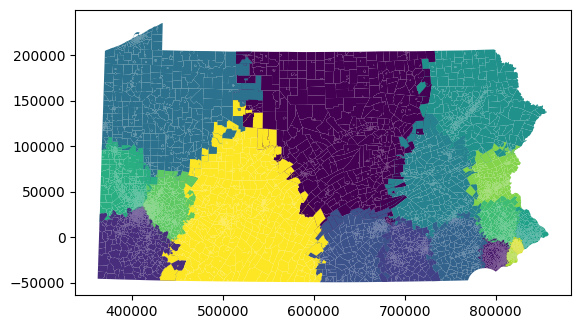

In [25]:
gdf_final.plot(column='DISTRICT')